In [1]:
import os.path

import matplotlib.pyplot as plt
import matplotlib

import wandb
import pandas as pd
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils
import numpy as np

/home/mbortkie/miniconda3/envs/c_r_l/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
plt.style.use("default")
plt.rcParams["legend.title_fontsize"] = "large"
plt.rcParams.update({'font.size': 12})
matplotlib.rc("xtick", labelsize=48)
matplotlib.rc("ytick", labelsize=48)

In [3]:
# Initialize the wandb API
api = wandb.Api()

# Define your project and entity (replace with your specific values)
entity = "cl-probing"  # e.g., your username or team name
project = "logsumexp_penalty"  # e.g., your project name
figures_path = f"./figures/{project}"
os.makedirs(figures_path, exist_ok=True)

In [4]:
metric = "eval/episode_success_any"
metric_label = "Success rate"
window_size = 10  # for smoothing the results
env = "ant_u_maze"
env_title_mapping = {
    "ant_ball": "Ant Ball",
    "ant": "Ant",
    "ant_big_maze": "Ant Big Maze",
    "ant_u_maze": "Ant U-Maze",
}
plot_legend= True if env=="ant" else False

In [5]:
# TODO: wait for 0.0

exp_names = [
    # "ant_l_symmetric_infonce_ef_l2_p_0.0",
    "ant_l_symmetric_infonce_ef_l2_p_0.01",
    r"ant_l_symmetric_infonce_ef_l2",
    "ant_l_symmetric_infonce_ef_l2_p_1",
]

exp_names_mapping = {
    # "ant_l_symmetric_infonce_ef_l2_p_0.0": "Penalty coef = 0.0",
    "ant_l_symmetric_infonce_ef_l2_p_0.01": "Penalty coef = 0.01",
    "ant_l_symmetric_infonce_ef_l2": "Penalty coef = 0.1",
    "ant_l_symmetric_infonce_ef_l2_p_1": "Penalty coef = 1",
}

In [14]:
# Define filters for the run config (replace with your specific filters)
filters = {
    "config.batch_size": 256,  # example filter, modify as needed
    # "config.n_hidden": 2,
    # "config.h_dim": 256,
    # "config.use_ln": True,
    # "config.env_name": env,
    # "config.env_name": {"$in": list(env_title_mapping.keys())},
    "config.exp_name": {"$in": exp_names},
    # "name": {"$in": exp_names},
    "state": "finished"
}

# Fetch the runs from the API
runs = api.runs(path=f"{entity}/{project}", filters=filters)

In [15]:
len(runs)

60

In [8]:
# Function to extract metrics from runs
def extract_run_data(run):
    # Extract run config and metrics
    config = run.config
    summary = run.summary._json_dict
    # TODO: potentially just load csv
    if os.path.exists(f"./data/history_{run.id}.csv"):
        history = pd.read_csv(f"./data/history_{run.id}.csv")
    else:
        history = run.history(pandas=True)
        history.to_csv(f"./data/history_{run.id}.csv", index=False)
    # Combine run information into a single dictionary

    run_data = {
        "run_id": run.id,
        "name": run.name,
        **config,
        **summary
    }
    return run_data, history

def create_rliable_compatible_data(df, metric):
    return df[metric].to_numpy()

def moving_average_smoothing(data, window_size=3):
    """Apply a moving average filter to the last axis of the input data, ensuring no wrap-around."""
    pad_width = window_size // 2
    padded_data = np.pad(data, pad_width, mode='edge')
    smoothed = np.convolve(padded_data, np.ones(window_size)/window_size, mode='valid')
    return smoothed

In [9]:
# Loop through the runs and collect data
all_histories = []

for run in runs:
    run_data, history = extract_run_data(run)
    all_histories.append(history)

In [21]:
data = {exp_names_mapping[elem]:[] for elem in exp_names}
seeds = {exp_names_mapping[elem]: [] for elem in exp_names}
for run, history in zip(runs, all_histories):
    a = create_rliable_compatible_data(history, metric)
    if a.shape != (50, ):
        print(run.name, a.shape, "Skipping")
        continue
    
    data[exp_names_mapping[run.config["exp_name"]]].append(a)
    seeds[exp_names_mapping[run.config["exp_name"]]].append(run.config["seed"])

ant_l_symmetric_infonce_ef_l2_p_0.1 (2,) Skipping
ant_l_symmetric_infonce_ef_l2_p_0.1 (2,) Skipping


In [22]:
data

{'Penalty coef = 0.01': [array([0.015625 , 0.0078125, 0.0390625, 0.0625   , 0.1015625, 0.1484375,
         0.1796875, 0.09375  , 0.2109375, 0.1640625, 0.15625  , 0.265625 ,
         0.1796875, 0.1875   , 0.2578125, 0.234375 , 0.21875  , 0.1640625,
         0.25     , 0.2109375, 0.15625  , 0.2265625, 0.203125 , 0.1484375,
         0.203125 , 0.1640625, 0.234375 , 0.125    , 0.203125 , 0.1953125,
         0.203125 , 0.203125 , 0.2109375, 0.1484375, 0.2265625, 0.25     ,
         0.203125 , 0.234375 , 0.21875  , 0.2890625, 0.28125  , 0.2890625,
         0.2734375, 0.3046875, 0.3515625, 0.25     , 0.359375 , 0.265625 ,
         0.3125   , 0.21875  ]),
  array([0.       , 0.03125  , 0.0625   , 0.1328125, 0.140625 , 0.15625  ,
         0.1640625, 0.1953125, 0.171875 , 0.203125 , 0.21875  , 0.2265625,
         0.2734375, 0.1875   , 0.1953125, 0.1484375, 0.2109375, 0.1640625,
         0.1875   , 0.234375 , 0.21875  , 0.265625 , 0.140625 , 0.2578125,
         0.21875  , 0.25     , 0.203125 , 0.

In [23]:
data = {key: np.array(elem)[:,None,:] for key, elem in data.items()}

In [25]:
# TODO: same shapes assert
for exp_name in exp_names:
    print(exp_name, data[exp_names_mapping[exp_name]].shape)

ant_l_symmetric_infonce_ef_l2_p_0.01 (20, 1, 50)
ant_l_symmetric_infonce_ef_l2 (18, 1, 50)
ant_l_symmetric_infonce_ef_l2_p_1 (20, 1, 50)


In [26]:
for key, item in data.items():
    data[key] = np.apply_along_axis(moving_average_smoothing, axis=-1, arr=item) 


In [27]:
np.arange(0, 55, 5)

array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50])

In [28]:
data_flattened = {key: np.mean(elem[:,:, -10:], axis=-1) for key, elem in data.items()}

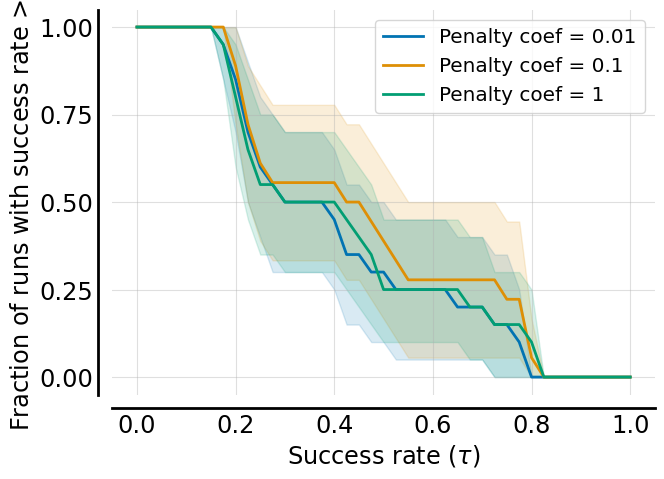

In [29]:
import seaborn as sns

# Load ALE scores as a dictionary mapping algorithms to their human normalized
# score matrices, each of which is of size `(num_runs x num_games)`.
# Human normalized score thresholds
thresholds = np.linspace(0.0, 1, 41)
score_distributions, score_distributions_cis = rly.create_performance_profile(
    data_flattened, thresholds
)
# Plot score distributions
fig, ax = plt.subplots(ncols=1, figsize=(7, 5))
plot_utils.plot_performance_profiles(
    score_distributions,
    thresholds,
    performance_profile_cis=score_distributions_cis,
    colors=dict(zip(list(data_flattened.keys()), sns.color_palette("colorblind"))),
    xlabel=rf"{metric_label} $(\tau)$",
    ylabel=r"Fraction of runs with success rate > $\tau$",
    ax=ax,
    legend=True,
    legendsize="large",
    grid_alpha=0.4
)

plt.savefig(os.path.join(figures_path, f"{metric_label}_performance_profile.png"), bbox_inches="tight")

General idea here: combine plots of episode_success and episode_success_any, so that we show, that even episode_success_any is goo, the episode_success is worse than when using logsumexp. Then we can create a narration, that it helps with exploration, as we also observe lower episode_reward_survive when using logsumexp.